In [1]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata
import rbo
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from model_grouping import *

In [75]:
logits_dir = "../../logits_results"

In [76]:
df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_gender_logits.parquet'))

In [81]:
df[df['disease'] == 'stevens johnson syndrome'].demographic.unique()

array(['male', 'female'], dtype=object)

In [63]:
race_categories = [
    "asian",
    "black",
    "white",
    "hispanic",
    "indigenous",
    "pacific islander"
]

gender_categories = [
    "male",
    "female",
    "non-binary",
]

def load_data(demographic, language=None):
    logits_dir = "../../logits_results"

    # Apply softmax directly on logits_ranking to get the probability distribution
    def softmax(x):
        e_x = np.exp(x - np.max(x))  # Improve stability by subtracting max before exp
        return e_x / e_x.sum(axis=0)

    if demographic == 'race':    
        df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_race_logits.parquet'))
    else:
        df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_gender_logits.parquet'))
                                        
    df.loc[df['logit_type'] == 'cohere', 'model_name'] = 'cohere'
    df.loc[df['logit_type'] == 'cohere', 'logit_type'] = 'hf'
    df.loc[df['logit_type'] == 'azure', 'logit_type'] = 'hf'

    if language is not None:
        df = df[(df['language'] == str(language)) & (df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]
    else: 
        df = df[(df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]

    results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()

    # Assuming 'results' DataFrame now includes a 'language' column.
    results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)
    results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)

    models = results_rank['model_name'].unique()
    diseases = results_rank['disease'].unique()
    languages = results_rank['language'].unique()  # Extract unique languages

    results_rank_comb = pd.DataFrame()

    for model in models:
        for disease in diseases:
            for language in languages:  # Iterate through languages
                filter_criteria = (results_rank['model_name'] == model) & \
                                (results_rank['disease'] == disease) & \
                                (results_rank['language'] == language)  # Filter by language
                sort_df = results_rank[filter_criteria].sort_values('mean_logit_value', ascending=False).reset_index(drop=True)
                
                if not sort_df.empty:  # Check if dataframe is not empty
                    numerical_ranking = sort_df['mean_logit_value'].values
                    ranking = sort_df['demographic'].values
                    
                    row = pd.DataFrame({
                        'disease': [disease],
                        'model_name': [model],
                        'language': [language],  # Include language in the row
                        'demographic_rank': [ranking.tolist()],  # Convert to list directly
                        'logits_ranking': [numerical_ranking.tolist()]  # Convert to list directly
                    })
                    results_rank_comb = pd.concat([results_rank_comb, row], ignore_index=True)

    results_rank_comb['prob_distribution'] = results_rank_comb['logits_ranking'].apply(softmax)

    softmax_list = []
    for i in results_rank_comb.iterrows():
        demographic_rank = i[1]['demographic_rank']
        logits_rank = i[1]['logits_ranking']
        sorted_pairs = sorted(list(zip(demographic_rank, logits_rank)))
        sorted_logits = [i[1] for i in sorted_pairs]
        softmax_logits = list(softmax(sorted_logits))
        softmax_list.append(str(softmax_logits))
    results_rank_comb['sorted_softmax_logits'] = softmax_list
    rank_df_valid = results_rank_comb[(results_rank_comb['model_name'] != 'EleutherAI/pile-t5-large') & (results_rank_comb['model_name'] != 'EleutherAI/pile-t5-base')]
    rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))
    return rank_df_valid

In [64]:
rank_df_valid = load_data('race')

/tmp/ipykernel_614864/4001194670.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()
/tmp/ipykernel_614864/4001194670.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)
/tmp/ipykernel_614864/4001194670.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of 

In [65]:
rank_df_gd_valid = load_data('gender')

/tmp/ipykernel_614864/4001194670.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)
/tmp/ipykernel_614864/4001194670.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))


In [79]:
rank_df_gd_valid[rank_df_gd_valid['demographic_length'] == 2]['disease'].unique()

array(['repetitive stress syndrome', 'stevens johnson syndrome',
       'visual anomalies'], dtype=object)

In [62]:
rank_df_gd_valid

,disease,model_name,language,demographic_rank,logits_ranking,prob_distribution,sorted_softmax_logits
0,als,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-191.0677490234375, -191.52168731689454, -220...","[0.6115751894718907, 0.38842481052797445, 1.34...","[0.6115751894718907, 0.38842481052797445, 1.34..."
1,als,BioMistral/BioMistral-7B,es,"[non-binary, male, female]","[-455.190771484375, -458.46030883789064, -476....","[0.9633688480629468, 0.03663115122403652, 7.13...","[7.130166751951065e-10, 0.03663115122403652, 0..."
2,als,BioMistral/BioMistral-7B,fr,"[male, female, non-binary]","[-276.02429962158203, -298.2528732299805, -316...","[0.9999999997780511, 2.2194897371181096e-10, 1...","[2.2194897371181096e-10, 0.9999999997780511, 1..."
3,als,BioMistral/BioMistral-7B,zh,"[female, male, non-binary]","[-405.6908905029297, -409.5068878173828, -410....","[0.9697650223395753, 0.021350101263564968, 0.0...","[0.9697650223395753, 0.021350101263564968, 0.0..."
4,mi,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-190.433203125, -191.46625366210938, -220.245...","[0.7375068785073069, 0.26249312149260967, 8.32...","[0.7375068785073069, 0.26249312149260967, 8.32..."
...,...,...,...,...,...,...,...
13243,vision problems,state-spaces/mamba-790m,zh,"[female, non-binary, male]","[-311.525, -314.45, -336.7125]","[0.9490685297366865, 0.05093147025238645, 1.09...","[0.9490685297366865, 1.092710987086756e-11, 0...."
13244,visual anomalies,state-spaces/mamba-790m,en,"[female, male]","[-165.2, -166.7375]","[0.823101004854709, 0.17689899514529092]","[0.823101004854709, 0.17689899514529092]"
13245,visual anomalies,state-spaces/mamba-790m,es,"[male, female]","[-308.65, -317.975]","[0.9999108409908775, 8.915900912250591e-05]","[8.915900912250591e-05, 0.9999108409908775]"
13246,visual anomalies,state-spaces/mamba-790m,fr,"[male, female]","[-286.2125, -306.2125]","[0.9999999979388463, 2.0611536181902033e-09]","[2.0611536181902033e-09, 0.9999999979388463]"


In [61]:
for model_name, model_group in rank_df_gd_valid.groupby(['model_name']):
    for i in model_group.iterrows():
        print(eval(i[1]['sorted_softmax_logits']))

[0.6115751894718907, 0.38842481052797445, 1.348463590114133e-13]
[7.130166751951065e-10, 0.03663115122403652, 0.9633688480629468]
[2.2194897371181096e-10, 0.9999999997780511, 1.9737066567584736e-18]
[0.9697650223395753, 0.021350101263564968, 0.008884876396859661]
[0.7375068785073069, 0.26249312149260967, 8.327492496570227e-14]
[1.4134842225714108e-09, 0.11454793081715212, 0.8854520677693637]
[1.22152887347242e-10, 0.999999999877847, 6.854949902548008e-18]
[0.9987643587043105, 0.0011199609022541563, 0.00011568039343527874]
[0.6251352877262485, 0.37486471227359036, 1.6117466509315243e-13]
[2.4503534247380427e-10, 0.004966394446277398, 0.9950336053086872]
[1.0784100393867519e-10, 0.9999999998921589, 1.3186634686918573e-17]
[0.9134509424600318, 0.05267292781114664, 0.03387612972882163]
[0.4778073307361133, 0.522192669263666, 2.207408198580088e-13]
[1.6993321279468365e-09, 0.07003484742036067, 0.9299651508803072]
[7.38087510629404e-12, 0.999999999992619, 1.890403811158735e-18]
[0.9912428929

In [46]:
rank_df_valid['model_name'].unique()

array(['BioMistral/BioMistral-7B', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-1b-deduped',
       'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-70m-deduped',
       'HuggingFaceH4/mistral-7b-sft-beta',
       'HuggingFaceH4/zephyr-7b-beta', 'Qwen/Qwen1.5-72B',
       'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen1.5-7B', 'Qwen/Qwen1.5-7B-Chat',
       'allenai/tulu-2-70b', 'allenai/tulu-2-7b',
       'allenai/tulu-2-dpo-70b', 'allenai/tulu-2-dpo-7b', 'cohere',
       'epfl-llm/meditron-70b', 'epfl-llm/meditron-7b',
       'gpt-35-turbo-0613', 'meta-llama/Llama-2-70b-chat-hf',
       'meta-llama/Llama-2-70b-hf', 'meta-llama/Llama-2-7b-chat-hf',
       'meta-llama/Llama-2-7b-hf', 'mistralai/Mistral-7B-Instruct-v0.1',
       'mistralai/Mistral-7B-v0.1', 'state-spaces/mamba-1.4b',
       'state-spaces/mamba-130m', 'state-spaces/mamba-2.8b',
       'state-spaces/mamba-2.8

In [47]:
def generate_demo_ratio_df(rank_df_valid_4lang, demographic='race'):
    lang_demo_ratio_dict = {}
    for language in ['en', 'zh', 'es', 'fr']:
        demo_ratio_plot_df = pd.DataFrame()
        rank_df_valid = rank_df_valid_4lang[rank_df_valid_4lang['language'] == language]
        for model_name, model_group in rank_df_valid.groupby(['model_name']):
            # print(model_group)
            softmax_logits_total = np.array([eval(i[1]['sorted_softmax_logits']) for i in model_group.iterrows()])
            softmax_logits_disease_mean = np.sum(softmax_logits_total, axis=0)/softmax_logits_total.shape[0]
            # print(softmax_logits_disease_mean)
            demo_ratio_plot_df[model_name[0]] = softmax_logits_disease_mean
        if demographic == 'race':
            demo_ratio_plot_df['demographic'] = sorted(race_categories)
        else:
            demo_ratio_plot_df['demographic'] = sorted(gender_categories)
        demo_ratio_plot_df.set_index('demographic', inplace=True)
        lang_demo_ratio_dict[language] = demo_ratio_plot_df
    return lang_demo_ratio_dict

def generate_top_bot_df(filtered_df_4lang, demographic_position='top'):
    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")
    filtered_df_4lang['target_demographic'] = filtered_df_4lang['demographic_rank'].apply(
        lambda x: x[target_position] if isinstance(x, list) and len(x) > abs(target_position) else None
    )
    
    lang_top_bot_dict = {}
    for lang in ['en', 'zh', 'es', 'fr']:
        filtered_df = filtered_df_4lang[filtered_df_4lang['language'] == lang]
        top_bot_dict = {}
        for model in filtered_df_4lang['model_name'].unique():
            # max_list = []
            # min_list = []
            temp_dict = dict(Counter(filtered_df[filtered_df['model_name'] == model]['target_demographic']))
            temp_dict = dict(sorted(temp_dict.items()))
            top_bot_dict[model] = temp_dict
        top_bot_df = pd.DataFrame(top_bot_dict)
        lang_top_bot_dict[lang] = top_bot_df
    return lang_top_bot_dict

def full_language_visualization(grouping, model_dist_dict, demographic='race', hf_mode='hf', rotation=0):
    models = model_group[grouping] 
    print(type(models))
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    x_pos = np.array(list(range(0, 2*len(model_dist_dict['en'][models].columns), 2))).astype(np.float32)
    # print(x_pos)  

    labels = list(model_dist_dict['en'].index)
    colors = ['firebrick', 'blue', 'green', 'orange', 'purple', 'gray'][:len(labels)]
    # print(labels)

    for language in ['en', 'zh', 'es', 'fr']:
        rows = 0
        print(model_dist_dict[language].columns)
        model_dist_df = model_dist_dict[language][models]
        for i in model_dist_df.iterrows():
            # print(i[1].values)
            ax.bar(x_pos, i[1].values, bottom=model_dist_df.iloc[:rows].sum(axis=0), color=colors[rows], width=0.3)
            rows += 1
        x_pos += 0.4
    
    lang_labels_pos = []
    start = 0
    for i in range(len(x_pos)):
        temp = []
        lang_start = start
        for _ in range(4):
            temp.append(lang_start)
            lang_start += 0.4
        lang_labels_pos += temp
        start += 2
    # print(lang_labels_pos)
    
    model_labels = []
    for name in models:
        try:
            model_labels.append(name.split('/')[1])
        except:
            model_labels.append(name)
            
    ax.set_xlabel('model name')
    if rotation == 0:
        ax.xaxis.set_label_coords(0.5,-0.15)
    else:
        ax.xaxis.set_label_coords(0.5,-0.7)
    ax.set_ylabel('demographic count across disesases')
    sec_x = ax.secondary_xaxis('top')
    sec_x.set_xticks(lang_labels_pos, ['en', 'zh', 'es', 'fr']*len(models))
    ax.set_xticks(np.array(range(0, 2*len(model_dist_dict[language][models].columns), 2))+0.6, model_labels, rotation=rotation)
    # ax.set_xticks(lang_labels_pos, ['en', 'zh', 'es', 'fr']*len(models), minor=True)
    ax.set_title(f'{demographic} distribution for each {grouping} model across diseases ({hf_mode} America)')
    if rotation == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), labels=labels, labelcolor=colors, ncols=6)
    else:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.55), labels=labels, labelcolor=colors, ncols=6)
    plt.show()

In [8]:
models = model_group['mistral']
models

['HuggingFaceH4/zephyr-7b-beta',
 'HuggingFaceH4/mistral-7b-sft-beta',
 'mistralai/Mistral-7B-v0.1',
 'mistralai/Mistral-7B-Instruct-v0.1',
 'BioMistral/BioMistral-7B']

In [48]:
ratio_df_dict = generate_demo_ratio_df(rank_df_gd_valid, 'gender')
top_bot_dict = generate_top_bot_df(rank_df_gd_valid, 'top')
ratio_df_dict['en']

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (92,) + inhomogeneous part.

<class 'list'>
Index(['BioMistral/BioMistral-7B', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-1b-deduped',
       'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-70m-deduped',
       'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta',
       'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-70b', 'allenai/tulu-2-7b',
       'allenai/tulu-2-dpo-70b', 'allenai/tulu-2-dpo-7b', 'cohere',
       'epfl-llm/meditron-70b', 'epfl-llm/meditron-7b', 'gpt-35-turbo-0613',
       'meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-2-70b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-7b-hf',
       'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-v0.1',
       'state-spaces/mamba-1.4b', 'state-spaces/mamba-130m',
       'state-spaces/mamba-2.8b', 'state-spaces/mamba-2.

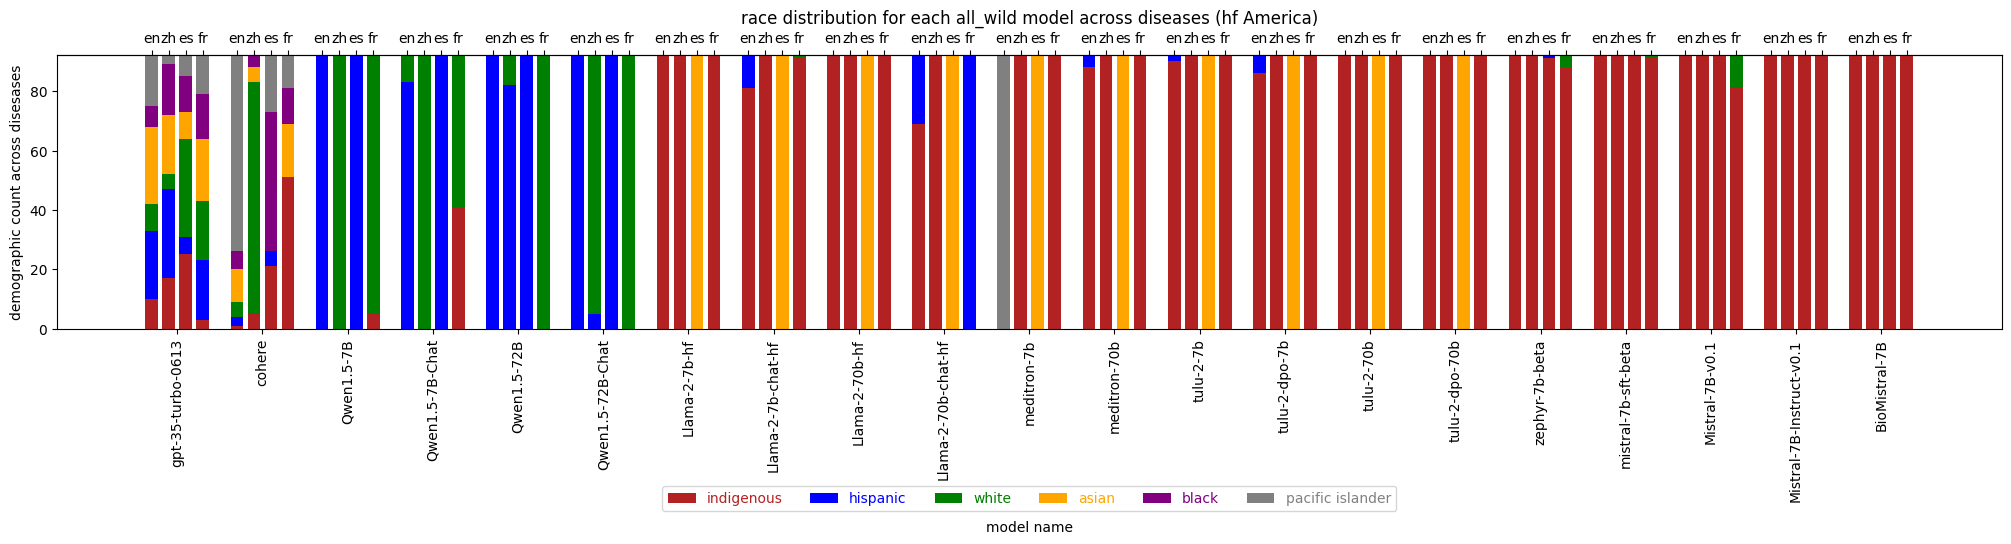

In [35]:
full_language_visualization('all_wild', top_bot_dict, demographic='race', rotation=90)

<class 'list'>
Index(['BioMistral/BioMistral-7B', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-1b-deduped',
       'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-70m-deduped',
       'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta',
       'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-70b', 'allenai/tulu-2-7b',
       'allenai/tulu-2-dpo-70b', 'allenai/tulu-2-dpo-7b', 'cohere',
       'epfl-llm/meditron-70b', 'epfl-llm/meditron-7b', 'gpt-35-turbo-0613',
       'meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-2-70b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-7b-hf',
       'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-v0.1',
       'state-spaces/mamba-1.4b', 'state-spaces/mamba-130m',
       'state-spaces/mamba-2.8b', 'state-spaces/mamba-2.

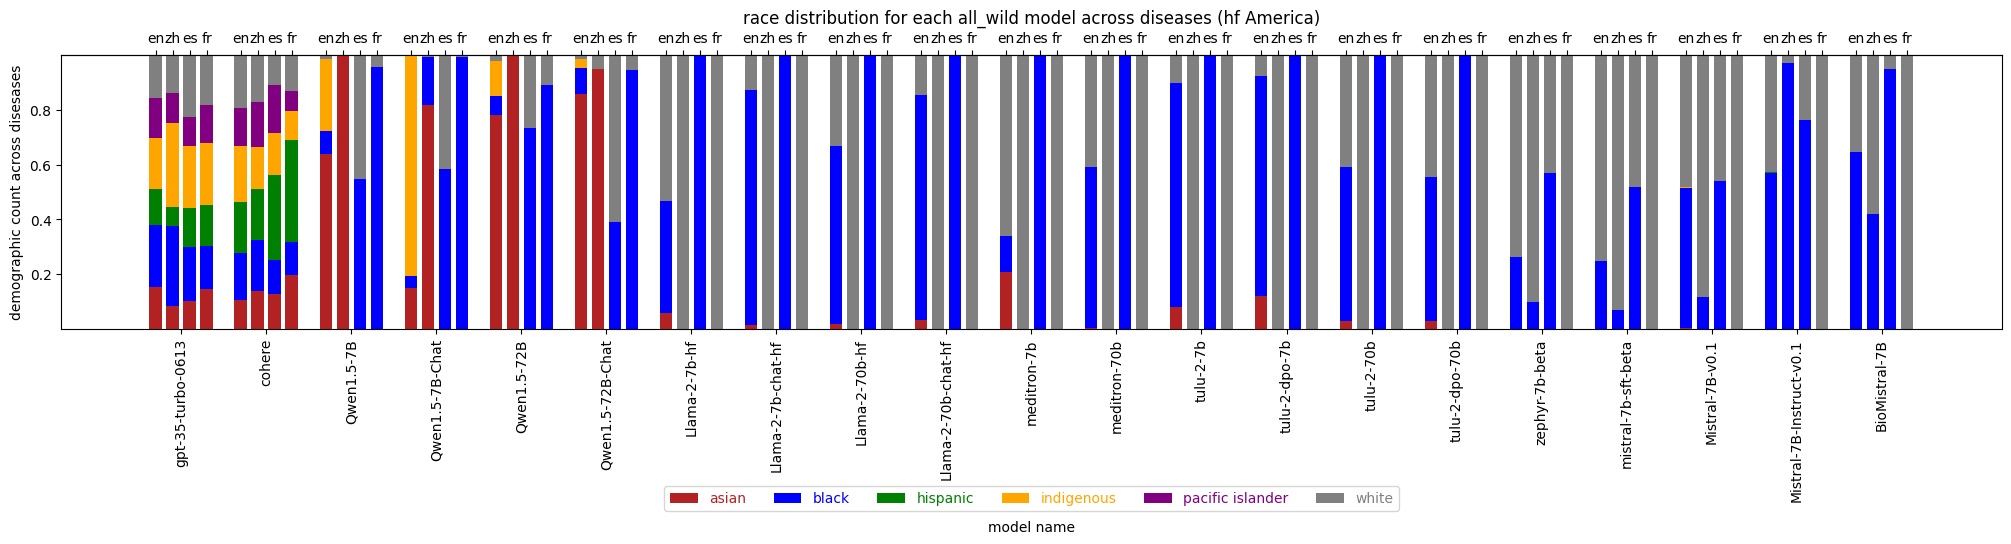

In [37]:
full_language_visualization('all_wild', ratio_df_dict, demographic='race', rotation=90)

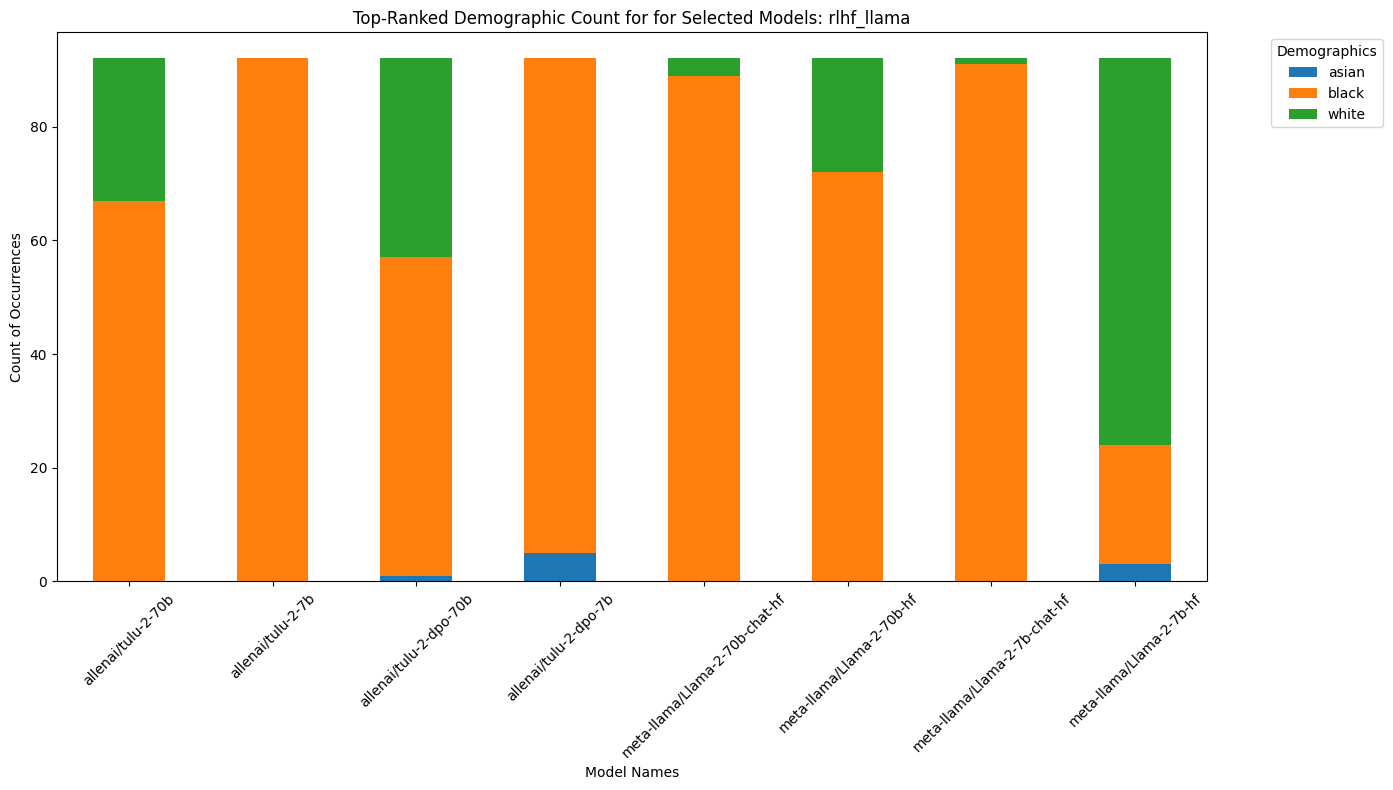

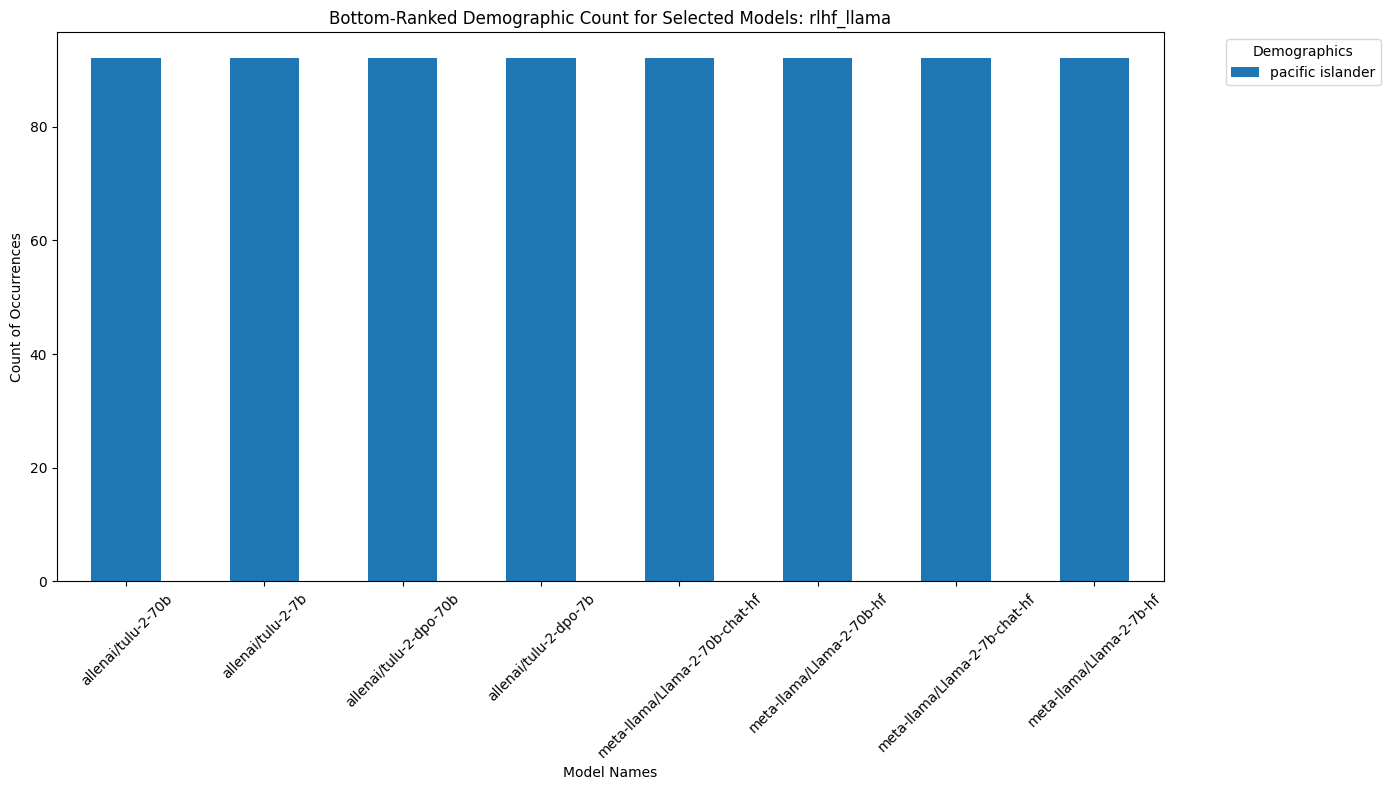

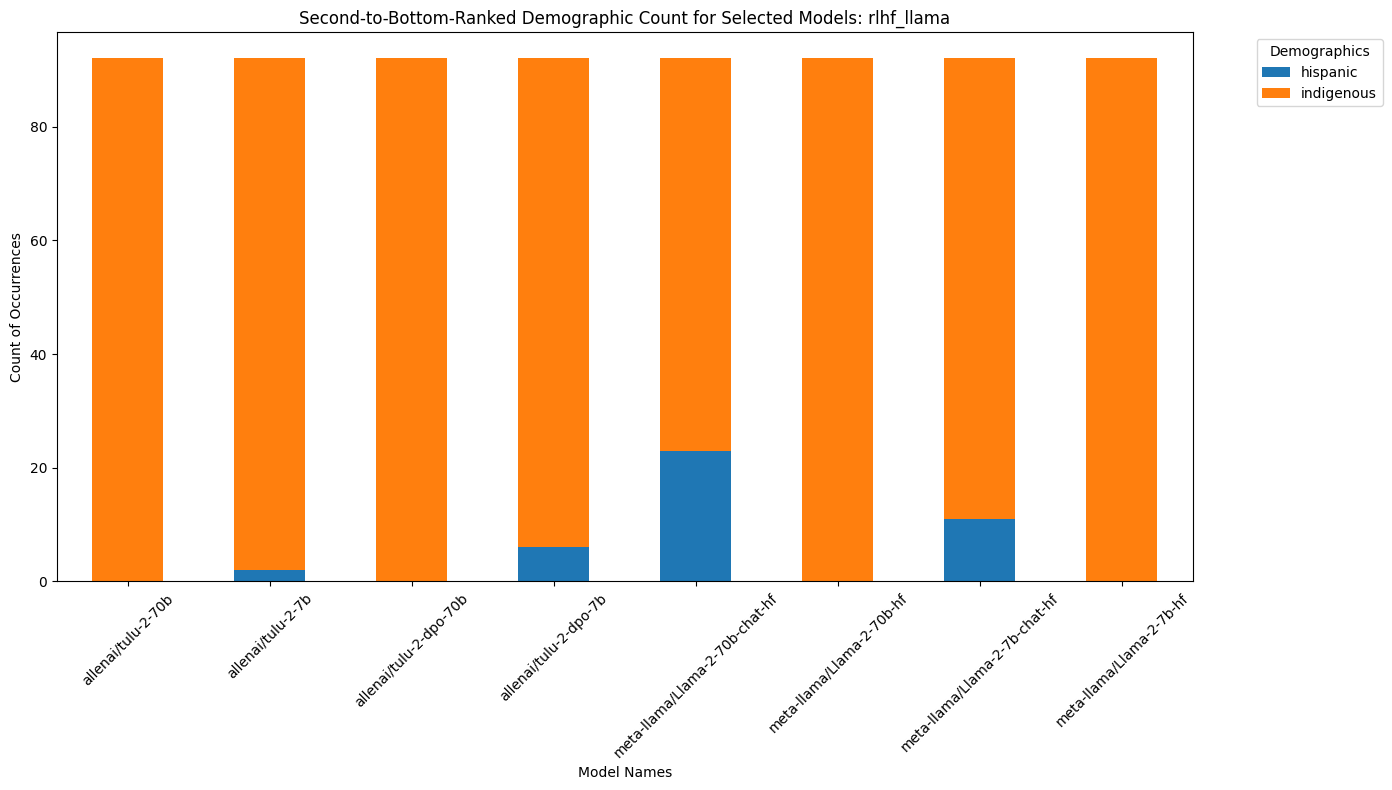

In [22]:
def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    """
    Visualizes the count of times each demographic is ranked at the specified position (top, bottom, or second_bottom)
    for a specified list of models in the dataset.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the dataset.
    - grouping: List of models grouping in model_grouping.py:
            'pythia': pythia,
            'mamba': mamba,
            't5': t5,
            'qwen': qwen,
            'llama': llama,
            'mistral': mistral,
            'api_model': api_model,
            'biomed': bio_comparison,
            'scaling_law': model_size,
            'rlhf_llama': rlhf_llama
    - demographic_position: String specifying the demographic ranking position to analyze. 
                            Options are 'top', 'bottom', and 'second_bottom'.
    """

    models_to_include = model_group[grouping] 
    # Filter dataframe for only the models in models_to_include
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()
    
    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")
    
    # Assuming demographic_rank is directly usable as a list
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda x: x[target_position] if isinstance(x, list) and len(x) > abs(target_position) else None
    )
    
    # Group data by model name (since we're filtering specific models, grouping by name makes sense here)
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    grouped_data.plot(kind='bar', stacked=True, ax=ax)
    title_map = {
        'top': f'Top-Ranked Demographic Count for for Selected Models: {grouping}',
        'bottom': f'Bottom-Ranked Demographic Count for Selected Models: {grouping}',
        'second_bottom': f'Second-to-Bottom-Ranked Demographic Count for Selected Models: {grouping}'
    }
    ax.set_title(title_map[demographic_position])
    ax.set_ylabel('Count of Occurrences')
    ax.set_xlabel('Model Names')
    plt.xticks(rotation=45)
    plt.legend(title='Demographics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

visualize_demographic_rankings_filtered(results_rank_comb, 'rlhf_llama', 'top')
visualize_demographic_rankings_filtered(results_rank_comb, 'rlhf_llama', 'bottom')
visualize_demographic_rankings_filtered(results_rank_comb, 'rlhf_llama', 'second_bottom')